<a href="https://colab.research.google.com/github/Tosin5S/yield/blob/main/cyps_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Preprocessing

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load the CSV file
file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/2020-04-07t051218phenotype_download.csv'
data = pd.read_csv(file_path)

# Inspect the first few rows of the dataframe to understand its structure
print("Data preview:\n", data.head())

# Identify columns that are truly numeric
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

# Further check for columns that might contain non-numeric data
for col in numeric_cols:
    if not pd.api.types.is_numeric_dtype(data[col]):
        print(f"Column {col} contains non-numeric data and will be excluded.")
        numeric_cols.remove(col)

# Print the verified numeric columns
print("Verified Numeric Columns:", numeric_cols)

# Perform median imputation only on the verified numeric columns
numeric_imputer = SimpleImputer(strategy='median')
numeric_data_imputed = numeric_imputer.fit_transform(data[numeric_cols])

# Ensure the imputed data matches the expected shape
if numeric_data_imputed.shape[1] == len(numeric_cols):
    # Reassign the imputed values back to the DataFrame
    data[numeric_cols] = numeric_data_imputed
    print("Imputation successful.")
else:
    print(f"Shape mismatch: Imputed data shape {numeric_data_imputed.shape} does not match expected columns {len(numeric_cols)}.")

# Check for any remaining NaN values in numeric columns
remaining_na = data[numeric_cols].isna().sum()
print("Remaining NaN values in numeric columns:\n", remaining_na)

# Save the cleaned data to a new CSV file
cleaned_file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/cleaned_2020-04-07t051218phenotype_download.csv'
data.to_csv(cleaned_file_path, index=False)

print(f"Cleaned data saved to {cleaned_file_path}")


Data preview:
    studyYear  programDbId programName  \
0       2016          162        IITA   
1       2016          162        IITA   
2       2016          162        IITA   
3       2016          162        IITA   
4       2016          162        IITA   

                               programDescription  studyDbId       studyName  \
0  IITA cassava breeding program, Ibadan, Nigeria       3325  16uyt10whtrtIB   
1  IITA cassava breeding program, Ibadan, Nigeria       3325  16uyt10whtrtIB   
2  IITA cassava breeding program, Ibadan, Nigeria       3325  16uyt10whtrtIB   
3  IITA cassava breeding program, Ibadan, Nigeria       3325  16uyt10whtrtIB   
4  IITA cassava breeding program, Ibadan, Nigeria       3325  16uyt10whtrtIB   

                                    studyDescription studyDesign  plotWidth  \
0  Assessment of Varieties of Cassava for high yi...        RCBD          6   
1  Assessment of Varieties of Cassava for high yi...        RCBD          6   
2  Assessment of Var

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames'
 'cassava mosaic disease incidence 6-month evaluation|CO_334:0000198']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Cleaned data saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/cleaned_2020-04-07t051218phenotype_download.csv


Model Development

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the cleaned CSV file
uncleaned_output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
data = pd.read_csv(uncleaned_output_file)

# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Create preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Impute missing values if any
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/test_random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)

print(f"Model saved to {joblib_file}")

# Make predictions on new data (if available)
# new_data = pd.DataFrame(...)  # Replace with your new data
# new_predictions = model_pipeline.predict(new_data)
# print("Predictions on new data:", new_predictions)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSee

ValueError: Input contains NaN.

Cleaned data for model development

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the cleaned CSV file
cleaned_file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/cleaned_2020-04-07t051218phenotype_download.csv'
cleaned_file_path_1 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/001_cleaned_2020-04-07t051218phenotype_download.csv'
cleaned_file_path_2 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/002_cleaned_2020-04-07t042528phenotype_download.csv'
cleaned_file_path_3 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/003_cleaned_2020-04-07t042435phenotype_download.csv'
cleaned_file_path_4 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/004_cleaned_2020-04-07t042451phenotype_download.csv'
cleaned_file_path_5 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/005_cleaned_2020-04-07t051234phenotype_download.csv'
cleaned_file_path_6 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/006_cleaned_2020-04-07t042558phenotype_download.csv'
cleaned_file_path_7 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/007_cleaned_2020-04-07t042543phenotype_download.csv'
cleaned_file_path_9 = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/009_cleaned_merged_phenotype_download.csv"

cleaned_output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/cleaned_merged_phenotype_download.csv"

dp_cleaned_merged = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/dp_cleaned_merged_phenotype_download.csv"

data = pd.read_csv(cleaned_file_path_9)

# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns


# Define preprocessing pipelines (without missing value handling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Only scale numeric values
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/cleaned/009_cleaned_random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)

print(f"Model saved to {joblib_file}")

# Make predictions on new data (if available)
# new_data = pd.DataFrame(...)  # Replace with your new data
# new_predictions = model_pipeline.predict(new_data)
# print("Predictions on new data:", new_predictions)

Mean Squared Error: 0.4093863017659819
R-squared: 0.9965697104189627
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/cleaned/009_cleaned_random_forest_model.pkl


Uncleaned data for model development

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the cleaned CSV file
cleaned_file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/2020-04-07t051218phenotype_download.csv'
uncleaned_file_path_1 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/001_2020-04-07t051218phenotype_download.csv'
uncleaned_file_path_2 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/002_2020-04-07t042528phenotype_download.csv'
uncleaned_file_path_3 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/003_2020-04-07t042435phenotype_download.csv'
uncleaned_file_path_4 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/004_2020-04-07t042451phenotype_download.csv'
uncleaned_file_path_5 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/005_2020-04-07t051234phenotype_download.csv'
uncleaned_file_path_6 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/006_2020-04-07t042558phenotype_download.csv'
uncleaned_file_path_7 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/007_2020-04-07t042543phenotype_download.csv'

uncleaned_output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"

data = pd.read_csv(uncleaned_output_file)

# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Define preprocessing pipelines (to keep missing values)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),  # Replace NaNs with -999
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Replace NaNs with 'Unknown'
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/uncleaned/uncleaned_random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)

print(f"Model saved to {joblib_file}")

# Make predictions on new data (if available)
# new_data = pd.DataFrame(...)  # Replace with your new data
# new_predictions = model_pipeline.predict(new_data)
# print("Predictions on new data:", new_predictions)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


ValueError: Input contains NaN.

In [7]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.ensemble import HistGradientBoostingRegressor

# Load the uncleaned merged CSV file
uncleaned_output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
data = pd.read_csv(uncleaned_output_file)

# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Drop rows where the target is NaN
data = data.dropna(subset=[target])

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns




# Define preprocessing pipelines (to keep missing values)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),  # Replace NaNs with -999
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Replace NaNs with 'Unknown'
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/uncleaned/uncleaned_random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)

print(f"Model saved to {joblib_file}")


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Mean Squared Error: 0.08813951724138101
R-squared: 0.9993524531085038
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/uncleaned/uncleaned_random_forest_model.pkl


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the uncleaned merged CSV file
uncleaned_output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
data = pd.read_csv(uncleaned_output_file)

# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Drop rows where the target is NaN
data = data.dropna(subset=[target])

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Define preprocessing pipelines (without missing value handling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Only scale numeric values
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)


print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"MAE: {MAE}")


# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/uncleaned/uncleaned_random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)

print(f"Model saved to {joblib_file}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Mean Squared Error: 1.1480778323818075
R-squared: 0.9915652563705512
MAE: 0.5516630350292069
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/uncleaned/uncleaned_random_forest_model.pkl


Prediction

In [ ]:
import pandas as pd
import joblib

# Load the trained model pipeline
model_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl"
model_pipeline = joblib.load(model_file)

# Inspect the pipeline steps to find the correct name for the final step
print(model_pipeline.named_steps)

# Extract feature names from the preprocessor
numeric_features = model_pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_features = model_pipeline.named_steps['preprocessor'].transformers_[1][2]

# Ensure they are lists
numeric_features = list(numeric_features) if not isinstance(numeric_features, list) else numeric_features
categorical_features = list(categorical_features) if not isinstance(categorical_features, list) else categorical_features

# Prepare new data (ensure it has the same columns as the training data)
# Replace this with your actual new data
new_data = pd.DataFrame({
    'cassava anthractnose disease severity in 9-month|CO_334:0000185': [3],
})

# Ensure all required columns are present in the new data
all_features = numeric_features + categorical_features

for col in all_features:
    if col not in new_data.columns:
        new_data[col] = 0  # Fill with default value, adjust as necessary

# Select only the columns used in training
new_data = new_data[all_features]

# Preprocess the new data using the same pipeline
new_data_preprocessed = model_pipeline.named_steps['preprocessor'].transform(new_data)

# Make predictions on the new data
new_predictions = model_pipeline.named_steps['regressor'].predict(new_data_preprocessed)

print("Predictions on new data:", new_predictions)


{'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 Index(['studyYear', 'programDbId', 'studyDbId', 'plotWidth', 'plotLength',
       'fieldSize', 'fieldTrialIsPlannedToBeGenotyped',
       'fieldTrialIsPlannedToCross', 'locationDbId', 'germplasmDbId',
       'germplasmSynonyms', 'observationUnitDbId', 'replicate', 'blockNumber',
       'plotNumber', 'rowNum...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['programName', 'programDescription', 'studyName', 'studyDescription',
       'studyDesign'

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames'
 'cassava mosaic disease incidence 6-month evaluation|CO_334:0000198']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Precision, F1 score and Recall  The metrics and evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import pandas as pd

# Load the cleaned CSV file
file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/cleaned_2020-04-07t051218phenotype_download.csv'
data = pd.read_csv(file_path)

# Define the original continuous target variable
target = 'fresh root yield|CO_334:0000013'
X = data.drop(columns=[target])
y = data[target]

# Discretize y into binary classes (e.g., high vs. low yield)
threshold = y.median()
y_class = (y > threshold).astype(int)

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Build a classification pipeline instead of a regression pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.4, random_state=42)

# Train the classification model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model using classification metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Save the trained classifier to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_classifier.pkl"
joblib.dump(model_pipeline, joblib_file)
print(f"Model saved to {joblib_file}")


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_classifier.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames'
 'cassava mosaic disease incidence 6-month evaluation|CO_334:0000198']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plan

Random Forest Regressor

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the cleaned CSV file
cleaned_file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/cleaned_2020-04-07t051218phenotype_download.csv'
data = pd.read_csv(cleaned_file_path)

# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Create preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values if any
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)

print(f"Model saved to {joblib_file}")

# Make predictions on new data (if available)
# new_data = pd.DataFrame(...)  # Replace with your new data
# new_predictions = model_pipeline.predict(new_data)
# print("Predictions on new data:", new_predictions)

Mean Squared Error: 6.631723082499985
R-squared: 0.7349345291747185
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames'
 'cassava mosaic disease incidence 6-month evaluation|CO_334:0000198']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plan

Feature Importance Metrics

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # Ensure this is imported
import joblib

# Load the cleaned CSV file
cleaned_file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/cleaned_2020-04-07t051218phenotype_download.csv'
data = pd.read_csv(cleaned_file_path)


# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)
print(f"Model saved to {joblib_file}")

# --- Extracting Feature Importances ---
# Retrieve the preprocessor from the pipeline
preprocessor = model_pipeline.named_steps['preprocessor']

# For numeric features, the names remain unchanged
num_features = list(numeric_cols)

# For categorical features, get the feature names from the one-hot encoder
# Note: get_feature_names_out is available in recent versions of scikit-learn
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols).tolist()

# Combine all feature names in the order they appear after transformation
feature_names = num_features + cat_features

# Get feature importances from the RandomForestRegressor
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Get the complete list of feature names after preprocessing
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Number of features:", len(feature_names))
print("Importances length:", len(model_pipeline.named_steps['regressor'].feature_importances_))

# Create a DataFrame with the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_pipeline.named_steps['regressor'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show full column names in output
pd.set_option('display.max_colwidth', None)
print("feature_names.tolist: ", feature_names.tolist())

count_features = len(feature_names.tolist())
print("Count of features:", count_features)


print(feature_importance_df)



/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames'
 'cassava mosaic disease incidence 6-month evaluation|CO_334:0000198']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plan

Mean Squared Error: 6.631723082499985
R-squared: 0.7349345291747185
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl
Number of features: 101
Importances length: 101
feature_names.tolist:  ['num__studyYear', 'num__programDbId', 'num__studyDbId', 'num__plotWidth', 'num__plotLength', 'num__fieldSize', 'num__locationDbId', 'num__germplasmDbId', 'num__observationUnitDbId', 'num__replicate', 'num__blockNumber', 'num__plotNumber', 'num__boiled storage root color visual 1-3|CO_334:0000114', 'num__cassava anthractnose disease incidence in 6-month|CO_334:0000181', 'num__cassava anthractnose disease incidence in 9-month|CO_334:0000182', 'num__cassava anthractnose disease severity in 6-month|CO_334:0000184', 'num__cassava anthractnose disease severity in 9-month|CO_334:0000185', 'num__cassava bacterial blight incidence 3-month evaluation|CO_334:0000178', 'num__cassava bacterial blight incidence 6-month evaluation|CO_334:0000179', 'num__c

data preprocessing (uncleaned data)
 on feature importance metrics

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # Ensure this is imported
import joblib

# Load the cleaned CSV file
cleaned_file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/2020-04-07t051218phenotype_download.csv'
uncleaned_file_path_1 = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
uncleaned_file_path_2 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/002_2020-04-07t042528phenotype_download.csv'
uncleaned_file_path_3 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/003_2020-04-07t042435phenotype_download.csv'
uncleaned_file_path_4 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/004_2020-04-07t042451phenotype_download.csv'
uncleaned_file_path_5 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/005_2020-04-07t051234phenotype_download.csv'
uncleaned_file_path_6 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/006_2020-04-07t042558phenotype_download.csv'
uncleaned_file_path_7 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/007_2020-04-07t042543phenotype_download.csv'

data = pd.read_csv(uncleaned_file_path_1)
data = data.dropna(subset=[target])  # Remove rows with missing target values

# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Define preprocessing pipelines (to keep missing values)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),  # Replace NaNs with -999
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Replace NaNs with 'Unknown'
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)
print(f"Model saved to {joblib_file}")

# --- Extracting Feature Importances ---
# Retrieve the preprocessor from the pipeline
preprocessor = model_pipeline.named_steps['preprocessor']

# For numeric features, the names remain unchanged
num_features = list(numeric_cols)

# For categorical features, get the feature names from the one-hot encoder
# Note: get_feature_names_out is available in recent versions of scikit-learn
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(categorical_cols).tolist()

# Combine all feature names in the order they appear after transformation
feature_names = num_features + cat_features

# Get feature importances from the RandomForestRegressor
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Get the complete list of feature names after preprocessing
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Number of features:", len(feature_names))
print("Importances length:", len(model_pipeline.named_steps['regressor'].feature_importances_))

# Create a DataFrame with the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_pipeline.named_steps['regressor'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show full column names in output
pd.set_option('display.max_colwidth', None)
print("feature_names.tolist: ", feature_names.tolist())

count_features = len(feature_names.tolist())
print("Count of features:", count_features)


print(feature_importance_df)



/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Mean Squared Error: 0.08813951724138101
R-squared: 0.9993524531085038
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl
Number of features: 403
Importances length: 403
feature_names.tolist:  ['num__studyYear', 'num__programDbId', 'num__studyDbId', 'num__plotWidth', 'num__plotLength', 'num__fieldSize', 'num__fieldTrialIsPlannedToBeGenotyped', 'num__fieldTrialIsPlannedToCross', 'num__locationDbId', 'num__germplasmDbId', 'num__germplasmSynonyms', 'num__observationUnitDbId', 'num__replicate', 'num__blockNumber', 'num__plotNumber', 'num__rowNumber', 'num__colNumber', 'num__plantNumber', 'num__plantedSeedlotStockDbId', 'num__plantedSeedlotStockUniquename', 'num__plantedSeedlotCurrentCount', 'num__plantedSeedlotCurrentWeightGram', 'num__plantedSeedlotBoxName', 'num__plantedSeedlotTransactionCount', 'num__plantedSeedlotTransactionWeight', 'num__plantedSeedlotTransactionDescription', 'num__availableGermplasmSeedlotUniquenames', 'num__b

data preprocessing (cleaned data) on feature importance metrics

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # Ensure this is imported
import joblib

# Load the cleaned CSV file
cleaned_file_path = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/cleaned/cleaned_2020-04-07t051218phenotype_download.csv'
cleaned_file_path_1 = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/009_cleaned_merged_phenotype_download.csv"
cleaned_file_path_2 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/002_cleaned_2020-04-07t042528phenotype_download.csv'
cleaned_file_path_3 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/003_cleaned_2020-04-07t042435phenotype_download.csv'
cleaned_file_path_4 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/004_cleaned_2020-04-07t042451phenotype_download.csv'
cleaned_file_path_5 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/005_cleaned_2020-04-07t051234phenotype_download.csv'
cleaned_file_path_6 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/006_cleaned_2020-04-07t042558phenotype_download.csv'
cleaned_file_path_7 = '/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/cleaned/007_cleaned_2020-04-07t042543phenotype_download.csv'

data = pd.read_csv(cleaned_file_path_1)


# Define the target variable
target = 'fresh root yield|CO_334:0000013'

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Define preprocessing pipelines (without missing value handling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Only scale numeric values
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data then applies the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Save the trained model to disk
joblib_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl"
joblib.dump(model_pipeline, joblib_file)
print(f"Model saved to {joblib_file}")

# --- Extracting Feature Importances ---
# Retrieve the preprocessor from the pipeline
preprocessor = model_pipeline.named_steps['preprocessor']

# For numeric features, the names remain unchanged
num_features = list(numeric_cols)

# For categorical features, get the feature names from the one-hot encoder
# Note: get_feature_names_out is available in recent versions of scikit-learn
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(categorical_cols).tolist()

# Combine all feature names in the order they appear after transformation
feature_names = num_features + cat_features

# Get feature importances from the RandomForestRegressor
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Get the complete list of feature names after preprocessing
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Number of features:", len(feature_names))
print("Importances length:", len(model_pipeline.named_steps['regressor'].feature_importances_))

# Create a DataFrame with the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_pipeline.named_steps['regressor'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show full column names in output
pd.set_option('display.max_colwidth', None)
print("feature_names.tolist: ", feature_names.tolist())

count_features = len(feature_names.tolist())
print("Count of features:", count_features)


#print(feature_importance_df)

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Adjust width as needed

# Then print the dataframe
print(feature_importance_df.to_string())


Mean Squared Error: 0.4093863017659819
R-squared: 0.9965697104189627
Model saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl
Number of features: 387
Importances length: 387
feature_names.tolist:  ['num__studyYear', 'num__programDbId', 'num__studyDbId', 'num__plotWidth', 'num__plotLength', 'num__fieldSize', 'num__locationDbId', 'num__germplasmDbId', 'num__observationUnitDbId', 'num__replicate', 'num__blockNumber', 'num__plotNumber', 'num__boiled storage root color visual 1-3|CO_334:0000114', 'num__cassava anthractnose disease incidence in 6-month|CO_334:0000181', 'num__cassava anthractnose disease incidence in 9-month|CO_334:0000182', 'num__cassava anthractnose disease severity in 6-month|CO_334:0000184', 'num__cassava anthractnose disease severity in 9-month|CO_334:0000185', 'num__cassava bacterial blight incidence 3-month evaluation|CO_334:0000178', 'num__cassava bacterial blight incidence 6-month evaluation|CO_334:0000179', 'num__

data preprocessing (uncleaned data) on model performance

In [15]:
import pandas as pd
import joblib

# Load the trained model pipeline
model_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/uncleaned/random_forest_model.pkl"
model_pipeline = joblib.load(model_file)

# Inspect the pipeline steps to find the correct name for the final step
print(model_pipeline.named_steps)

# Extract feature names from the preprocessor
numeric_features = model_pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_features = model_pipeline.named_steps['preprocessor'].transformers_[1][2]

# Ensure they are lists
numeric_features = list(numeric_features) if not isinstance(numeric_features, list) else numeric_features
categorical_features = list(categorical_features) if not isinstance(categorical_features, list) else categorical_features

# Prepare new data (ensure it has the same columns as the training data)
# Replace this with your actual new data
new_data = pd.DataFrame({
    'cassava anthractnose disease severity in 9-month|CO_334:0000185': [3],
})

# Ensure all required columns are present in the new data
all_features = numeric_features + categorical_features

for col in all_features:
    if col not in new_data.columns:
        new_data[col] = 0  # Fill with default value, adjust as necessary

# Select only the columns used in training
new_data = new_data[all_features]

# Preprocess the new data using the same pipeline
new_data_preprocessed = model_pipeline.named_steps['preprocessor'].transform(new_data)

# Make predictions on the new data
new_predictions = model_pipeline.named_steps['regressor'].predict(new_data_preprocessed)

print("Predictions on new data:", new_predictions)


{'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 Index(['studyYear', 'programDbId', 'studyDbId', 'plotWidth', 'plotLength', 'fieldSize', 'fieldTrialIsPlannedToBeGenotyped', 'fieldTrialIsPlannedToCross', 'locationDbId', 'germplasmDbId', 'germplasmSynonyms', 'observationUnitDbId', 'replicate', 'blockNumber', 'plotNumber', 'rowNum...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['programName', 'programDescription', 'studyName', 'studyDescription', 'studyDesign', 'plantingDate', 'harvestDate', 'l

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames'
 'cassava mosaic disease incidence 6-month evaluation|CO_334:0000198']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


data preprocessing (cleaned data) on model performance

In [ ]:
import pandas as pd
import joblib

# Load the trained model pipeline
model_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/model/random_forest_model.pkl"
model_pipeline = joblib.load(model_file)

# Inspect the pipeline steps to find the correct name for the final step
print(model_pipeline.named_steps)

# Extract feature names from the preprocessor
numeric_features = model_pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_features = model_pipeline.named_steps['preprocessor'].transformers_[1][2]

# Ensure they are lists
numeric_features = list(numeric_features) if not isinstance(numeric_features, list) else numeric_features
categorical_features = list(categorical_features) if not isinstance(categorical_features, list) else categorical_features

# Prepare new data (ensure it has the same columns as the training data)
# Replace this with your actual new data
new_data = pd.DataFrame({
    'cassava anthractnose disease severity in 9-month|CO_334:0000185': [3],
})

# Ensure all required columns are present in the new data
all_features = numeric_features + categorical_features

for col in all_features:
    if col not in new_data.columns:
        new_data[col] = 0  # Fill with default value, adjust as necessary

# Select only the columns used in training
new_data = new_data[all_features]

# Preprocess the new data using the same pipeline
new_data_preprocessed = model_pipeline.named_steps['preprocessor'].transform(new_data)

# Make predictions on the new data
new_predictions = model_pipeline.named_steps['regressor'].predict(new_data_preprocessed)

print("Predictions on new data:", new_predictions)


{'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 Index(['studyYear', 'programDbId', 'studyDbId', 'plotWidth', 'plotLength',
       'fieldSize', 'fieldTrialIsPlannedToBeGenotyped',
       'fieldTrialIsPlannedToCross', 'locationDbId', 'germplasmDbId',
       'germplasmSynonyms', 'observationUnitDbId', 'replicate', 'blockNumber',
       'plotNumber', 'rowNum...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['programName', 'programDescription', 'studyName', 'studyDescription',
       'studyDesign'

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['fieldTrialIsPlannedToBeGenotyped' 'fieldTrialIsPlannedToCross'
 'germplasmSynonyms' 'rowNumber' 'colNumber' 'plantNumber'
 'plantedSeedlotStockDbId' 'plantedSeedlotStockUniquename'
 'plantedSeedlotCurrentCount' 'plantedSeedlotCurrentWeightGram'
 'plantedSeedlotBoxName' 'plantedSeedlotTransactionCount'
 'plantedSeedlotTransactionWeight' 'plantedSeedlotTransactionDescription'
 'availableGermplasmSeedlotUniquenames'
 'cassava mosaic disease incidence 6-month evaluation|CO_334:0000198']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Load your data (assuming the same source for simplicity)
data = pd.read_csv("your_data.csv")
target = 'fresh root yield|CO_334:0000013'

# Prepare features and target
X = data.drop(columns=[target])
y = data[target]

# Drop rows with missing target values (common to both approaches)
data = data.dropna(subset=[target])
X = data.drop(columns=[target])
y = data[target]

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Pipeline for cleaned data (with more robust cleaning)
cleaned_numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cleaned_categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
cleaned_preprocessor = ColumnTransformer(transformers=[
    ('num', cleaned_numeric, numeric_cols),
    ('cat', cleaned_categorical, categorical_cols)
])
cleaned_pipeline = Pipeline(steps=[
    ('preprocessor', cleaned_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Pipeline for uncleaned data (minimal cleaning, e.g., placeholder imputation)
uncleaned_numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])
uncleaned_categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
uncleaned_preprocessor = ColumnTransformer(transformers=[
    ('num', uncleaned_numeric, numeric_cols),
    ('cat', uncleaned_categorical, categorical_cols)
])
uncleaned_pipeline = Pipeline(steps=[
    ('preprocessor', uncleaned_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data for a fair comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train and evaluate both models
cleaned_pipeline.fit(X_train, y_train)
uncleaned_pipeline.fit(X_train, y_train)

# Predictions
y_pred_clean = cleaned_pipeline.predict(X_test)
y_pred_unclean = uncleaned_pipeline.predict(X_test)

# Metrics
mse_clean = mean_squared_error(y_test, y_pred_clean)
r2_clean = r2_score(y_test, y_pred_clean)
mse_unclean = mean_squared_error(y_test, y_pred_unclean)
r2_unclean = r2_score(y_test, y_pred_unclean)

print("Cleaned Data - MSE:", mse_clean, "R2:", r2_clean)
print("Uncleaned Data - MSE:", mse_unclean, "R2:", r2_unclean)

# Cross-validation for more robust evaluation
cv_scores_clean = cross_val_score(cleaned_pipeline, X, y, cv=5, scoring='r2')
cv_scores_unclean = cross_val_score(uncleaned_pipeline, X, y, cv=5, scoring='r2')
print("Cleaned Data CV R2:", np.mean(cv_scores_clean))
print("Uncleaned Data CV R2:", np.mean(cv_scores_unclean))


Outliers

ValueError: List of boxplot statistics and `positions` values must have same the length

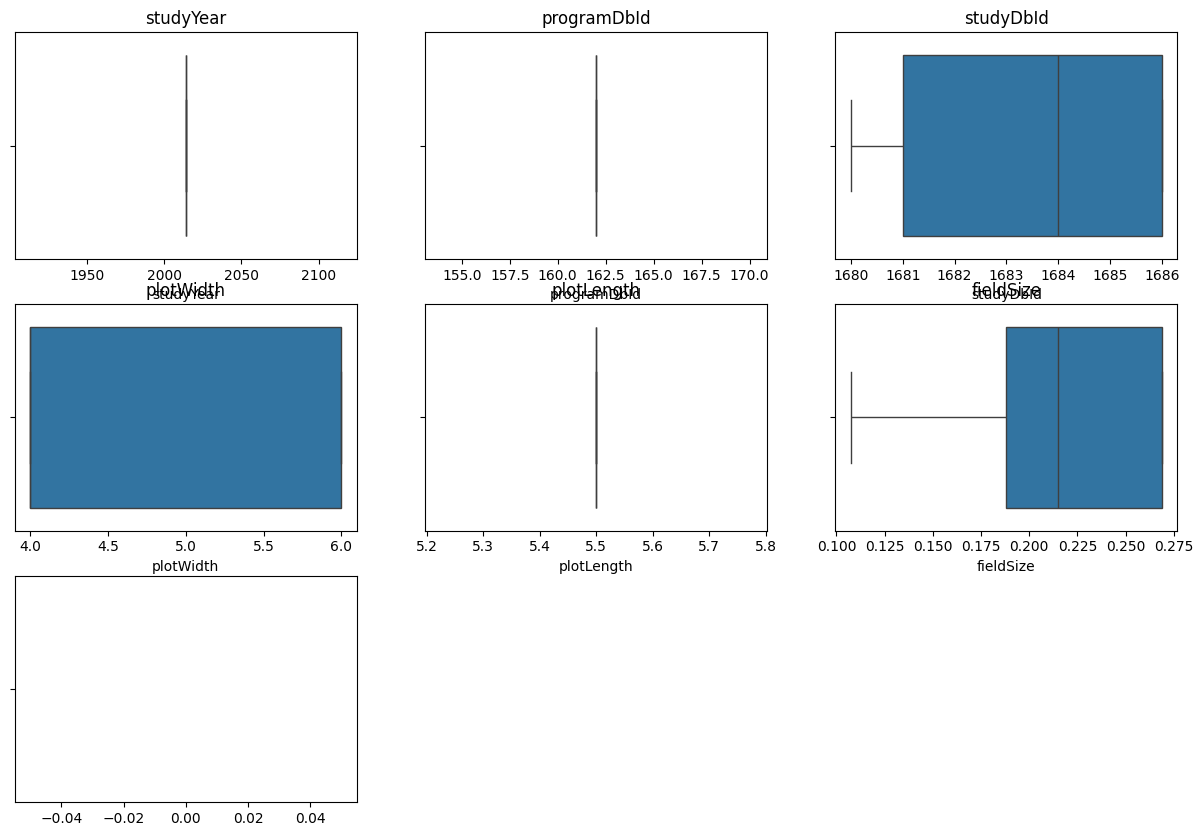

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv")

# Identify numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot boxplots for each numerical feature to visually inspect for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Calculate outliers using the IQR method for each numerical column
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers detected")


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
file_path = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
df = pd.read_csv(file_path)

# 2. Initial Data Exploration
print("Data Head:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

# 3. Remove Duplicate Rows
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"\nRemoved {initial_shape[0] - df.shape[0]} duplicate rows.")

# 4. Handle Missing Values
# Check the number of missing values per column
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Impute missing values:
# For numeric columns, use median; for non-numeric columns, use the mode.
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
    else:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

# 5. Outlier Detection and Removal (using IQR method)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return DataFrame filtered for non-outliers
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Identify numeric columns for outlier removal
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove outliers for each numeric column
for col in numeric_cols:
    original_count = df.shape[0]
    df = remove_outliers(df, col)
    new_count = df.shape[0]
    print(f"{col}: Removed {original_count - new_count} outliers.")

# 6. Encode Categorical Variables
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", categorical_cols)

# Convert categorical variables to dummy/indicator variables
if categorical_cols:
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 7. Feature Scaling for Numeric Variables
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 8. Visualize Data Distributions (Optional)
# Boxplots to verify outlier removal and scaling effect
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# 9. Save the Cleaned Dataset
output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/dp_cleaned_merged_phenotype_download.csv"
df.to_csv(output_file, index=False)
print(f"\nCleaned data saved to {output_file}")


Data Head:
   studyYear  programDbId programName  \
0       2014          162        IITA   
1       2014          162        IITA   
2       2014          162        IITA   
3       2014          162        IITA   
4       2014          162        IITA   

                               programDescription  studyDbId    studyName  \
0  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
1  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
2  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
3  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
4  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   

                                    studyDescription studyDesign  plotWidth  \
0  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
1  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
2  Biofortification of Cassava using Unifo

<ipython-input-33-fc7544fb5bc6>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
<ipython-input-33-fc7544fb5bc6>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

cassava bacterial blight severity 3-month evaluation|CO_334:0000175: Removed 0 outliers.
cassava bacterial blight severity 6-month evaluation|CO_334:0000176: Removed 0 outliers.
cassava brown streak disease root severity 12-month evaluation|CO_334:0000201: Removed 0 outliers.
cassava green mite severity first evaluation|CO_334:0000189: Removed 0 outliers.
cassava green mite severity second evaluation|CO_334:0000190: Removed 0 outliers.
cassava mosaic disease incidence 1-month evaluation|CO_334:0000195: Removed 0 outliers.
cassava mosaic disease incidence 3-month evaluation|CO_334:0000196: Removed 0 outliers.
cassava mosaic disease incidence 6-month evaluation|CO_334:0000198: Removed 0 outliers.
cassava mosaic disease severity 1-month evaluation|CO_334:0000191: Removed 0 outliers.
cassava mosaic disease severity 3-month evaluation|CO_334:0000192: Removed 0 outliers.
cassava mosaic disease severity 6-month evaluation|CO_334:0000194: Removed 0 outliers.
dry matter content by specific grav

ValueError: Found array with 0 sample(s) (shape=(0, 80)) while a minimum of 1 is required by StandardScaler.

Data Head:
   studyYear  programDbId programName  \
0       2014          162        IITA   
1       2014          162        IITA   
2       2014          162        IITA   
3       2014          162        IITA   
4       2014          162        IITA   

                               programDescription  studyDbId    studyName  \
0  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
1  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
2  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
3  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
4  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   

                                    studyDescription studyDesign  plotWidth  \
0  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
1  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
2  Biofortification of Cassava using Unifo

<ipython-input-35-d85246095d8c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].median())


germplasmDbId: Removed 156 outliers.
observationUnitDbId: Removed 12 outliers.
plotNumber: Removed 0 outliers.
cassava bacterial blight incidence 3-month evaluation|CO_334:0000178: Removed 7 outliers.
dry matter content by specific gravity method|CO_334:0000160: Removed 6 outliers.
dry yield|CO_334:0000014: Removed 6 outliers.
fresh root yield|CO_334:0000013: Removed 0 outliers.
fresh shoot weight measurement in kg per plot|CO_334:0000016: Removed 12 outliers.
fresh storage root weight per plot|CO_334:0000012: Removed 0 outliers.
plant stands harvested counting|CO_334:0000010: Removed 9 outliers.
root number counting|CO_334:0000011: Removed 0 outliers.
root weight in air|CO_334:0000157: Removed 5 outliers.
rotted storage root counting|CO_334:0000084: Removed 6 outliers.
sprout count at one-month|CO_334:0000213: Removed 7 outliers.
top yield|CO_334:0000017: Removed 4 outliers.
dry matter content percentage|CO_334:0000092: Removed 35 outliers.

Categorical columns: ['programName', 'progr

<ipython-input-35-d85246095d8c>:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


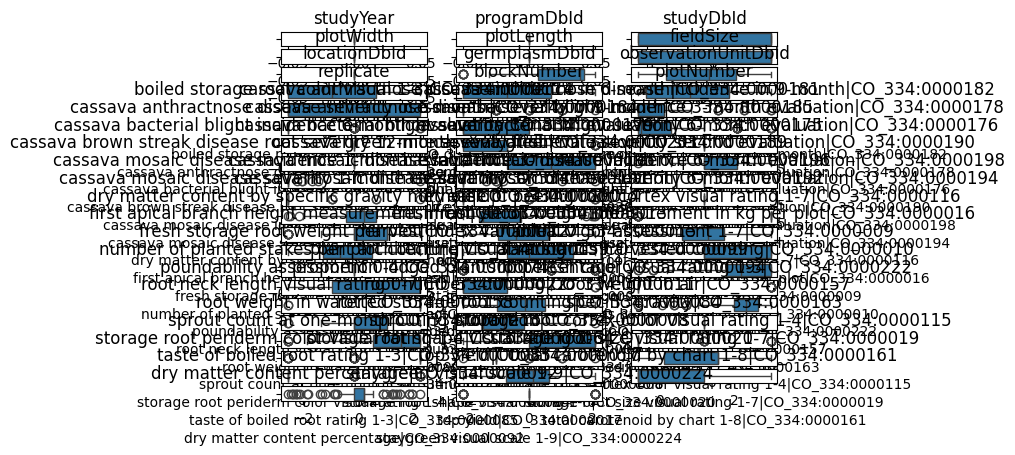


Cleaned data saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/dp_cleaned_merged_phenotype_download.csv


In [35]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
file_path = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
df = pd.read_csv(file_path)

# 2. Initial Data Exploration
print("Data Head:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

# 3. Remove Duplicate Rows
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"\nRemoved {initial_shape[0] - df.shape[0]} duplicate rows.")

# 4. Drop columns with excessive missing values (e.g., more than 50% missing)
missing_threshold = 0.5
cols_to_keep = df.columns[df.isnull().mean() < missing_threshold]
df = df[cols_to_keep]
print("\nColumns retained after dropping those with >50% missing values:")
print(df.columns.tolist())

# 5. Handle Missing Values for remaining columns:
# For numeric columns, fill missing with the median; for non-numeric columns, fill with the mode.
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        # Only fill if there are missing values
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    else:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

# 6. Outlier Detection and Removal (using IQR method)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Only filter on rows where the column is not null
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Identify numeric columns for outlier removal (after dropping columns with many missing values)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Optionally, you can skip outlier removal for columns with very few unique values or known issues
# For each numeric column, remove outliers
for col in numeric_cols:
    original_count = df.shape[0]
    # Only apply if there is a reasonable number of unique values (to avoid categorical-like behavior)
    if df[col].nunique() > 10:
        df = remove_outliers(df, col)
        new_count = df.shape[0]
        print(f"{col}: Removed {original_count - new_count} outliers.")

# Check if the DataFrame is empty after outlier removal
if df.empty:
    raise ValueError("DataFrame is empty after outlier removal. Consider revising your outlier detection criteria.")

# 7. Encode Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", categorical_cols)
if categorical_cols:
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 8. Feature Scaling for Numeric Variables
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 9. Visualize Data Distributions (Optional)
n = len(numeric_cols)  # e.g., 10
ncols = 3
nrows = math.ceil(n / ncols)
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# 10. Save the Cleaned Dataset
output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/dp_cleaned_merged_phenotype_download.csv"
df.to_csv(output_file, index=False)
print(f"\nCleaned data saved to {output_file}")


Data Head:
   studyYear  programDbId programName  \
0       2014          162        IITA   
1       2014          162        IITA   
2       2014          162        IITA   
3       2014          162        IITA   
4       2014          162        IITA   

                               programDescription  studyDbId    studyName  \
0  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
1  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
2  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
3  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
4  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   

                                    studyDescription studyDesign  plotWidth  \
0  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
1  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
2  Biofortification of Cassava using Unifo

<ipython-input-38-48b80e03134f>:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


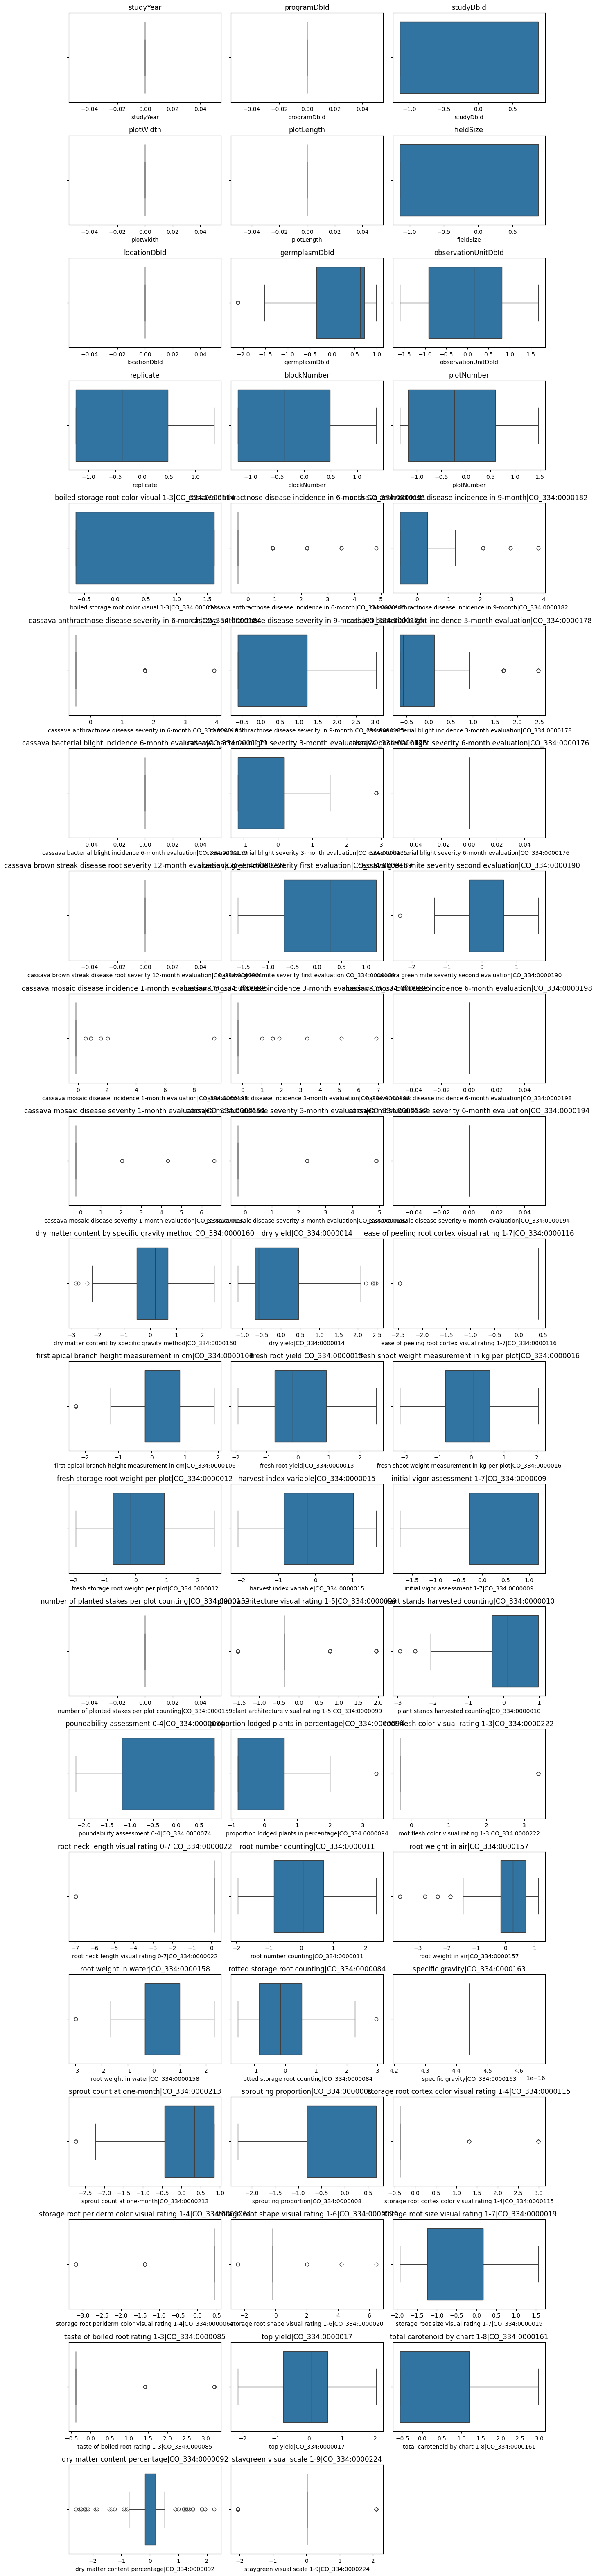


Cleaned data saved to /content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/dp_cleaned_merged_phenotype_download.csv


In [38]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def load_data(file_path):
    """Load the dataset and print initial exploration info."""
    df = pd.read_csv(file_path)
    print("Data Head:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nStatistical Summary:")
    print(df.describe())
    return df

def remove_duplicates(df):
    """Remove duplicate rows from the DataFrame."""
    initial_shape = df.shape
    df.drop_duplicates(inplace=True)
    print(f"\nRemoved {initial_shape[0] - df.shape[0]} duplicate rows.")
    return df

def drop_high_missing_columns(df, threshold=0.5):
    """
    Drop columns with a proportion of missing values greater than the threshold.

    Parameters:
    - df: DataFrame to process.
    - threshold: Maximum allowed fraction of missing data per column.
    """
    cols_to_keep = df.columns[df.isnull().mean() < threshold]
    df = df[cols_to_keep]
    print("\nColumns retained after dropping those with >50% missing values:")
    print(df.columns.tolist())
    return df

def fill_missing_values(df):
    """Fill missing values: numeric columns get the median, categorical columns get the mode."""
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            if df[col].isnull().sum() > 0:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            if df[col].isnull().sum() > 0:
                mode_val = df[col].mode()
                # If mode exists, fill with it; otherwise use a placeholder.
                if not mode_val.empty:
                    df[col].fillna(mode_val[0], inplace=True)
                else:
                    df[col].fillna("Unknown", inplace=True)
    return df

def remove_outliers(df, col, iqr_multiplier=1.5):
    """Remove outliers from a specific column using the IQR method."""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

def apply_outlier_removal(df, numeric_cols, iqr_multiplier=1.5, min_unique=10):
    """
    Remove outliers for numeric columns that have a sufficient number of unique values.

    Parameters:
    - df: DataFrame to process.
    - numeric_cols: List of numeric column names.
    - iqr_multiplier: Multiplier used to compute the outlier bounds.
    - min_unique: Minimum number of unique values required to perform outlier removal.
    """
    for col in numeric_cols:
        if df[col].nunique() > min_unique:
            original_count = df.shape[0]
            df = remove_outliers(df, col, iqr_multiplier)
            new_count = df.shape[0]
            print(f"{col}: Removed {original_count - new_count} outliers.")
            if df.empty:
                raise ValueError(f"DataFrame is empty after removing outliers in {col}. Adjust your outlier criteria.")
    return df

def encode_categorical_variables(df):
    """Encode categorical variables using one-hot encoding."""
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print("\nCategorical columns:", categorical_cols)
    if categorical_cols:
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df

def scale_features(df, numeric_cols):
    """Scale numeric features using StandardScaler."""
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

def visualize_numeric_columns(df, numeric_cols):
    """Visualize numeric column distributions using boxplots."""
    n = len(numeric_cols)
    ncols = 3
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(ncols * 4, nrows * 3))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(nrows, ncols, i)
        sns.boxplot(x=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()

def main():
    # Define file paths
    file_path = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
    output_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/dp_cleaned_merged_phenotype_download.csv"

    # 1. Load Data
    df = load_data(file_path)

    # 2. Remove Duplicates
    df = remove_duplicates(df)

    # 3. Drop Columns with Excessive Missing Values
    df = drop_high_missing_columns(df, threshold=0.5)

    # 4. Fill Missing Values
    df = fill_missing_values(df)

    # 5. Outlier Removal on Numeric Columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df = apply_outlier_removal(df, numeric_cols, iqr_multiplier=1.5, min_unique=10)

    # 6. Encode Categorical Variables
    df = encode_categorical_variables(df)

    # After encoding, recalculate numeric columns (if new ones were added)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # 7. Feature Scaling
    df = scale_features(df, numeric_cols)

    # 8. Visualize Numeric Data Distributions (Optional)
    visualize_numeric_columns(df, numeric_cols)

    # 9. Save the Cleaned Dataset
    df.to_csv(output_file, index=False)
    print(f"\nCleaned data saved to {output_file}")

if __name__ == "__main__":
    main()


In [2]:
import pandas as pd
import numpy as np

# ---------------------------
# 1. Load the Dataset
# ---------------------------
file_path = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
df = pd.read_csv(file_path)

# ---------------------------
# 2. Initial Data Exploration
# ---------------------------
print("=== First 5 Rows ===")
print(df.head(), "\n")

print("=== Dataset Information ===")
print(df.info(), "\n")

print("=== Summary Statistics (Numerical Columns) ===")
print(df.describe(), "\n")

print("=== Missing Values per Column ===")
print(df.isnull().sum(), "\n")

# ---------------------------
# 3. Remove Duplicate Rows
# ---------------------------
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Removed {initial_shape[0] - df.shape[0]} duplicate rows. New shape: {df.shape}\n")

# ---------------------------
# 4. Outlier Detection in Numeric Columns
# ---------------------------
# For each numeric column, use the IQR method to detect outliers.
# If outliers are present, we'll use the median for imputation,
# otherwise, we'll use the mean.
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
outlier_flags = {}  # Dictionary to store whether each column has outliers

print("=== Outlier Detection (IQR Method) ===")
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    has_outliers = len(outliers) > 0
    outlier_flags[col] = has_outliers
    imputation_method = "median" if has_outliers else "mean"
    print(f"Column '{col}' has {len(outliers)} outliers. Using {imputation_method} for imputation.")

# ---------------------------
# 5. Handling Missing Values for Numeric Columns
# ---------------------------
# Impute missing values using median if outliers exist; otherwise, use mean.
for col in num_cols:
    if df[col].isnull().any():
        if outlier_flags[col]:
            impute_value = df[col].median()
            df[col].fillna(impute_value, inplace=True)
            print(f"Filled missing values in numeric column '{col}' with median: {impute_value}")
        else:
            impute_value = df[col].mean()
            df[col].fillna(impute_value, inplace=True)
            print(f"Filled missing values in numeric column '{col}' with mean: {impute_value}")

# ---------------------------
# 6. Handling Missing Values for Categorical Columns
# ---------------------------
# Impute missing values using the mode.
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}")

# ---------------------------
# 7. Standardize Categorical Data
# ---------------------------
# Convert text to lowercase and remove extra whitespace.
for col in cat_cols:
    df[col] = df[col].str.strip().str.lower()

# ---------------------------
# 8. Save the Cleaned Dataset
# ---------------------------
clean_file_path = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/009_cleaned_merged_phenotype_download.csv"
df.to_csv(clean_file_path, index=False)
print(f"\nPreprocessing complete. Cleaned dataset saved to '{clean_file_path}'.")


=== First 5 Rows ===
   studyYear  programDbId programName  \
0       2014          162        IITA   
1       2014          162        IITA   
2       2014          162        IITA   
3       2014          162        IITA   
4       2014          162        IITA   

                               programDescription  studyDbId    studyName  \
0  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
1  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
2  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
3  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
4  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   

                                    studyDescription studyDesign  plotWidth  \
0  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
1  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
2  Biofortification of Cassava u

<ipython-input-2-0a114ae426db>:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(impute_value, inplace=True)
<ipython-input-2-0a114ae426db>:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

Data Preprocessing - Dropping of features with no value

In [3]:
import pandas as pd
import numpy as np

# ---------------------------
# 1. Load the Dataset
# ---------------------------
file_path = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"
df = pd.read_csv(file_path)

# ---------------------------
# 2. Initial Data Exploration
# ---------------------------
print("=== First 5 Rows ===")
print(df.head(), "\n")

print("=== Dataset Information ===")
print(df.info(), "\n")

print("=== Summary Statistics (Numerical Columns) ===")
print(df.describe(), "\n")

print("=== Missing Values per Column ===")
print(df.isnull().sum(), "\n")

# ---------------------------
# 3. Drop Columns with No Records (All Missing Values)
# ---------------------------
df.dropna(axis=1, how='all', inplace=True)
print("Dropped columns with no records (all missing values).")
print(f"New shape after dropping empty features: {df.shape}\n")

# ---------------------------
# 4. Remove Duplicate Rows
# ---------------------------
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Removed {initial_shape[0] - df.shape[0]} duplicate rows. New shape: {df.shape}\n")

# ---------------------------
# 5. Outlier Detection in Numeric Columns
# ---------------------------
# For each numeric column, use the IQR method to detect outliers.
# If outliers are present, we'll use the median for imputation;
# otherwise, we'll use the mean.
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
outlier_flags = {}  # Dictionary to store whether each column has outliers

print("=== Outlier Detection (IQR Method) ===")
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    has_outliers = len(outliers) > 0
    outlier_flags[col] = has_outliers
    imputation_method = "median" if has_outliers else "mean"
    print(f"Column '{col}' has {len(outliers)} outliers. Using {imputation_method} for imputation.")

# ---------------------------
# 6. Handling Missing Values for Numeric Columns
# ---------------------------
# Impute missing values using median if outliers exist; otherwise, use mean.
for col in num_cols:
    if df[col].isnull().any():
        if outlier_flags[col]:
            impute_value = df[col].median()
            df[col].fillna(impute_value, inplace=True)
            print(f"Filled missing values in numeric column '{col}' with median: {impute_value}")
        else:
            impute_value = df[col].mean()
            df[col].fillna(impute_value, inplace=True)
            print(f"Filled missing values in numeric column '{col}' with mean: {impute_value}")

# ---------------------------
# 7. Handling Missing Values for Categorical Columns
# ---------------------------
# Impute missing values using the mode.
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}")

# ---------------------------
# 8. Standardize Categorical Data
# ---------------------------
# Convert text to lowercase and remove extra whitespace.
for col in cat_cols:
    df[col] = df[col].str.strip().str.lower()

# ---------------------------
# 9. Save the Cleaned Dataset
# ---------------------------
clean_file_path = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/009_cleaned_merged_phenotype_download.csv"
df.to_csv(clean_file_path, index=False)
print(f"\nPreprocessing complete. Cleaned dataset saved to '{clean_file_path}'.")


=== First 5 Rows ===
   studyYear  programDbId programName  \
0       2014          162        IITA   
1       2014          162        IITA   
2       2014          162        IITA   
3       2014          162        IITA   
4       2014          162        IITA   

                               programDescription  studyDbId    studyName  \
0  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
1  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
2  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
3  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   
4  IITA cassava breeding program, Ibadan, Nigeria       1684  14uyt21pdIB   

                                    studyDescription studyDesign  plotWidth  \
0  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
1  Biofortification of Cassava using Uniform Yiel...        RCBD          4   
2  Biofortification of Cassava u

<ipython-input-3-1c0a1066e513>:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(impute_value, inplace=True)
<ipython-input-3-1c0a1066e513>:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: load your cleaned and uncleaned feature importance DataFrames
# They should each have columns: 'Feature' and 'Importance'
# For demonstration, we assume CSV files 'cleaned_data.csv' and 'uncleaned_data.csv'
df_clean = pd.read_csv("/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/009_cleaned_merged_phenotype_download.csv")      # Provided cleaned dataset feature importances
df_unclean = pd.read_csv("/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv")  # Uncleaned dataset feature importances

print(df_clean.columns)
print(df_unclean.columns)


# Merge the two DataFrames on the 'Feature' column
df_merged = pd.merge(df_clean, df_unclean, on='Feature', suffixes=('_clean', '_unclean'))

# Sort by the cleaned dataset's importance for clearer visualization
df_merged.sort_values(by='Importance_clean', inplace=True)

# Create a horizontal grouped bar chart
fig, ax = plt.subplots(figsize=(10, 12))
bar_width = 0.4
y_pos = range(len(df_merged))

ax.barh([i - bar_width/2 for i in y_pos], df_merged['Importance_clean'],
        height=bar_width, label='Cleaned', color='steelblue')
ax.barh([i + bar_width/2 for i in y_pos], df_merged['Importance_unclean'],
        height=bar_width, label='Uncleaned', color='coral')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_merged['Feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Comparison of Feature Importances: Cleaned vs. Uncleaned Datasets')
ax.legend()

plt.tight_layout()
plt.show()


Index(['studyYear', 'programDbId', 'programName', 'programDescription', 'studyDbId', 'studyName', 'studyDescription', 'studyDesign', 'plotWidth', 'plotLength', 'fieldSize', 'plantingDate', 'harvestDate', 'locationDbId', 'locationName', 'germplasmDbId', 'germplasmName', 'observationLevel', 'observationUnitDbId', 'observationUnitName', 'replicate', 'blockNumber', 'plotNumber', 'entryType', 'boiled storage root color visual 1-3|CO_334:0000114', 'cassava anthractnose disease incidence in 6-month|CO_334:0000181', 'cassava anthractnose disease incidence in 9-month|CO_334:0000182', 'cassava anthractnose disease severity in 6-month|CO_334:0000184', 'cassava anthractnose disease severity in 9-month|CO_334:0000185', 'cassava bacterial blight incidence 3-month evaluation|CO_334:0000178', 'cassava bacterial blight incidence 6-month evaluation|CO_334:0000179', 'cassava bacterial blight severity 3-month evaluation|CO_334:0000175',
       'cassava bacterial blight severity 6-month evaluation|CO_334:0

KeyError: 'Feature'

Cleaned data shape: (364, 64)
Uncleaned data shape: (364, 79)


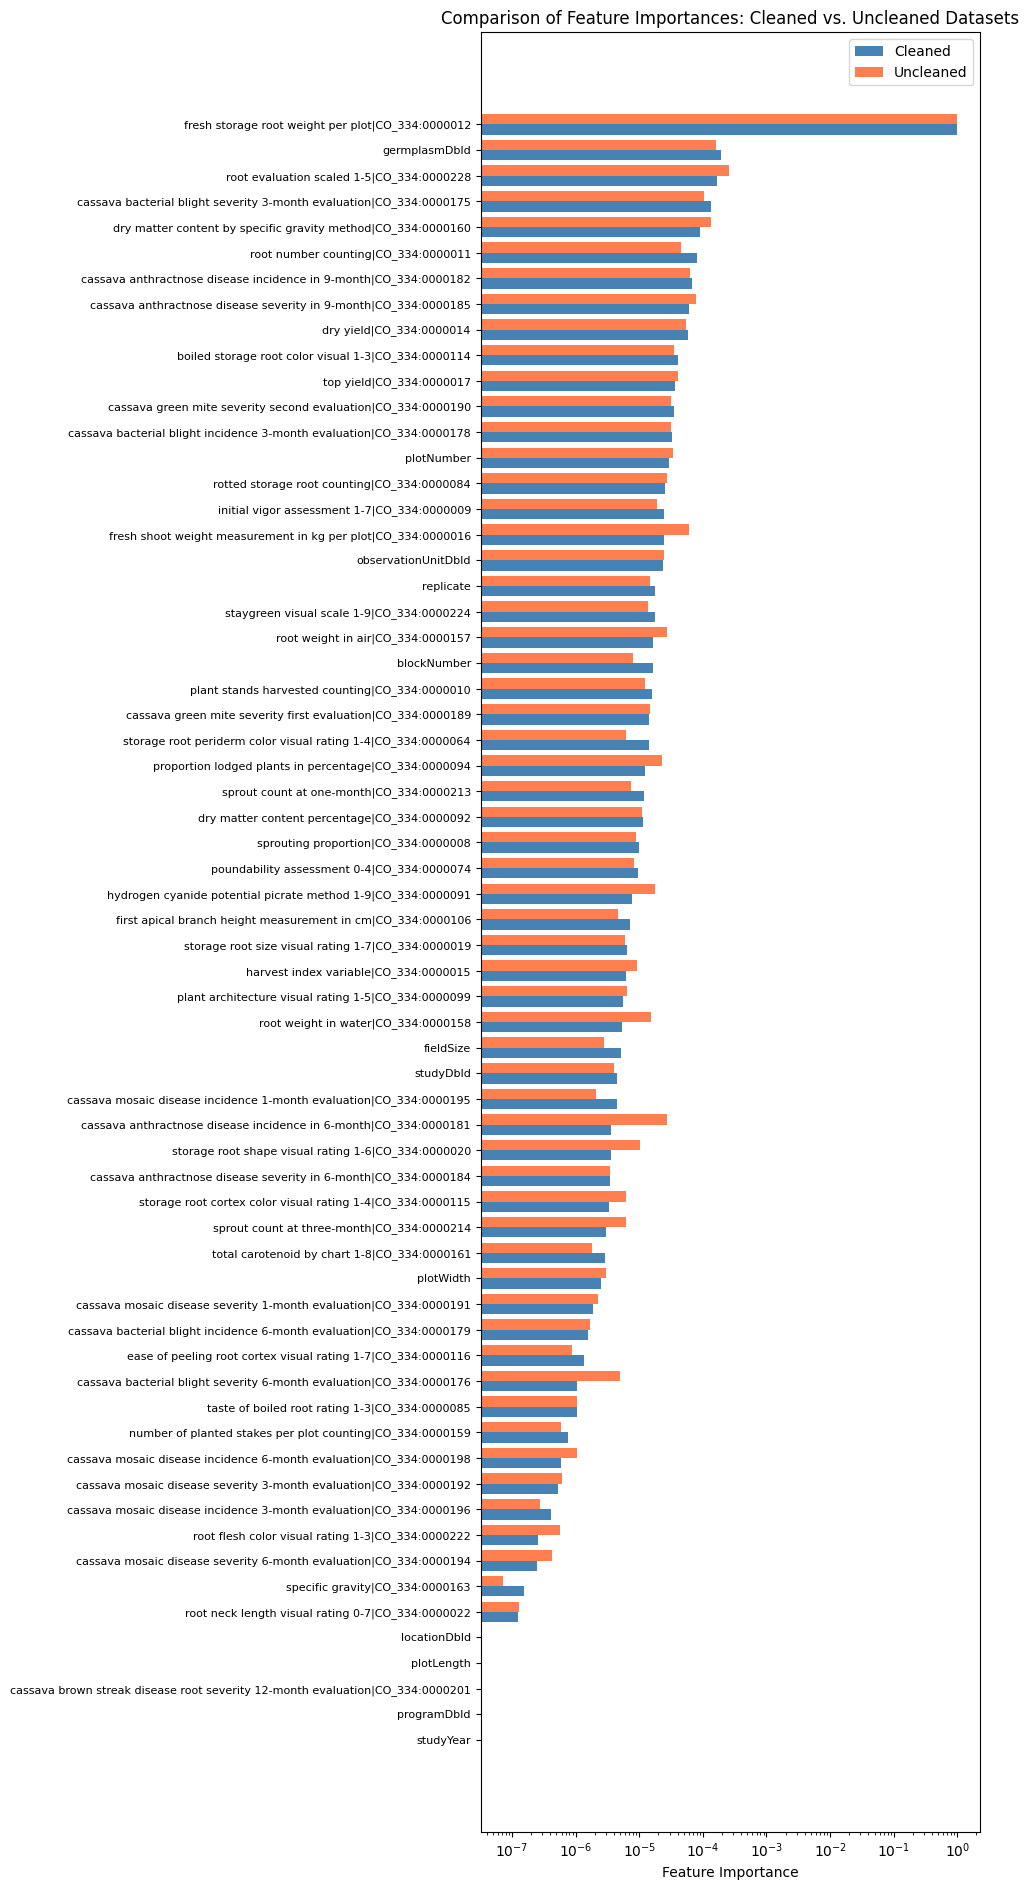

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Define file paths (adjust these paths as needed)
cleaned_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/009_cleaned_merged_phenotype_download.csv"
uncleaned_file = "/content/drive/MyDrive/01_December/DDIS/Data/Uniform_Yield_Trial/uncleaned/Data/uncleaned_merged_phenotype_download.csv"

# Load CSV files
df_clean = pd.read_csv(cleaned_file)
df_unclean = pd.read_csv(uncleaned_file)

# Choose a target variable; .
target_column = "fresh root yield|CO_334:0000013"

# Define a function to prepare data:
# Instead of dropping rows with missing values, we fill them with the median.
def prepare_data(df, target):
    # Select only numeric columns (features and target)
    df_numeric = df.select_dtypes(include=[np.number])
    # Fill missing values with the median for each column
    df_numeric = df_numeric.fillna(df_numeric.median())
    # Separate features and target
    X = df_numeric.drop(columns=[target])
    y = df_numeric[target]
    return X, y

# Prepare data for both cleaned and uncleaned datasets
X_clean, y_clean = prepare_data(df_clean, target_column)
X_unclean, y_unclean = prepare_data(df_unclean, target_column)

# Print the shape of the datasets to verify they have samples
print("Cleaned data shape:", X_clean.shape)
print("Uncleaned data shape:", X_unclean.shape)

# Train a RandomForestRegressor on the cleaned dataset
rf_clean = RandomForestRegressor(random_state=42)
rf_clean.fit(X_clean, y_clean)
importance_clean = rf_clean.feature_importances_
features_clean = X_clean.columns

# Train a RandomForestRegressor on the uncleaned dataset
rf_unclean = RandomForestRegressor(random_state=42)
rf_unclean.fit(X_unclean, y_unclean)
importance_unclean = rf_unclean.feature_importances_
features_unclean = X_unclean.columns

# Create DataFrames for the feature importances
df_imp_clean = pd.DataFrame({
    "Feature": features_clean,
    "Importance": importance_clean
})
df_imp_unclean = pd.DataFrame({
    "Feature": features_unclean,
    "Importance": importance_unclean
})

# Merge the two DataFrames on 'Feature'
df_merged = pd.merge(df_imp_clean, df_imp_unclean, on="Feature", suffixes=('_clean', '_unclean'))

# Sort by the importance from the cleaned dataset for clearer visualization
df_merged.sort_values(by="Importance_clean", inplace=True)

# Plot a horizontal grouped bar chart to compare the feature importances
fig, ax = plt.subplots(figsize=(10, len(df_merged) * 0.25 + 3))
bar_width = 0.4
y_pos = np.arange(len(df_merged))

ax.barh(y_pos - bar_width/2, df_merged["Importance_clean"], height=bar_width, label="Cleaned", color="steelblue")
ax.barh(y_pos + bar_width/2, df_merged["Importance_unclean"], height=bar_width, label="Uncleaned", color="coral")
ax.set_xscale("log")


ax.set_yticks(y_pos)
ax.set_yticklabels(df_merged["Feature"], fontsize=8)  # Adjust fontsize if needed
ax.set_xlabel("Feature Importance")
ax.set_title("Comparison of Feature Importances: Cleaned vs. Uncleaned Datasets")
ax.legend()

plt.tight_layout()
plt.show()
